In [1]:
data = open("output", "r")
text = data.read()
data.close()

# text = text[:10000]

In [2]:
from gensim.summarization.textcleaner import split_sentences
sentences = split_sentences(text)
text = None
model = None
data = None

In [3]:
from gensim.utils import simple_tokenize
sentences = [list(simple_tokenize(s.lower())) for s in sentences]

In [10]:
import pickle
for i in range(0,10000):
    if i*3000000 > 16528555:
        break
    d = (i+1) * 3000000
    
    if d > 16528555:
        d = 16528555
    
    pickle.dump( sentences[i*3000000:d], open( "sentences_tokenized"+str(i), "wb" ) )

In [1]:
import pickle
sentences = []
for i in range(0,4):
    sentences = sentences + pickle.load( open( "sentences_tokenized"+str(i), "rb" ) )

In [2]:
print(len(sentences))

12000000


In [3]:


from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sentences)
bigram = Phraser(phrases)

sentences = [bigram[s] for s in sentences] 

In [4]:
import pickle
pickle.dump( sentences, open( "sentences_phrased", "wb" ) )
pickle.dump( bigram, open( "bigram", "wb" ) )

In [1]:
import pickle
sentences = pickle.load( open( "sentences_phrased", "rb" ) )
bigram = pickle.load( open( "bigram", "rb" ) )

In [6]:
from gensim.models import Word2Vec

model = Word2Vec(size=300, window=5, min_count=3, sg=0)

model.build_vocab(sentences)
model.train(sentences, total_examples=len(sentences), epochs=6)

model.save("model")


In [63]:
def sims(phr):
    q = phr.lower().split()
    q = bigram[q]
    print(q[0] + ":")
    sim = model.wv.most_similar(positive=q, topn=3)
#     sim = [s for s, v in sim]
    print(sim)
    print("\n")
    
sims("Sąd Najwyższy")
sims("Trybunał Konstytucyjny")
sims("kodeks cywilny")
sims("kpk")
sims("sąd rejonowy")
sims("szkoda")
sims("wypadek")
sims("kolizja")
sims("szkoda majątkowa")
sims("nieszczęście")
sims("rozwód")

sąd_najwyższy:
[('najwyższy', 0.834610641002655), ('sąd_odwoławczy', 0.7045168876647949), ('sąd_apelacyjny', 0.703677773475647)]


trybunał_konstytucyjny:
[('trybunał', 0.9643449783325195), ('prokurator_generalny', 0.7042673826217651), ('marszałek_sejmu', 0.6854263544082642)]


kodeks_cywilny:
[('kodeks_karny', 0.7062203288078308), ('ordynacja_podatkowa', 0.6608834862709045), ('prawo_bankowe', 0.6471465229988098)]


kpk:
[('kpc', 0.6768637895584106), ('kk', 0.6506270170211792), ('kpa', 0.6211248636245728)]


sąd_rejonowy:
[('sąd_okręgowy', 0.8922678232192993), ('sąd_wojewódzki', 0.8531134128570557), ('sąd_apelacyjny', 0.7890136241912842)]


szkoda:
[('szkoda_majątkowa', 0.7147274017333984), ('krzywda', 0.7087323069572449), ('strata', 0.6433978080749512)]


wypadek:
[('przypadek', 0.5935612916946411), ('skutek', 0.5143119096755981), ('moment', 0.46816909313201904)]


kolizja:
[('dysproporcja', 0.7229409217834473), ('kumulacja', 0.647812008857727), ('sfera', 0.6313716769218445)]


szkoda

In [60]:
def tok(phr):
    q = phr.lower().split()
    return bigram[q]

def do_vec(phr):
    return model.wv[tok(phr)].reshape(300)

a = do_vec("Sąd najwyższy") - do_vec("kpc") + do_vec("konstytucja")
print("Sąd najwyższy - kpc + konstytucja =")
print(model.wv.similar_by_vector(a,topn=5))
print("\n")

print("pasażer - mężczyzna + kobieta =")
b = do_vec("pasażer") - do_vec("mężczyzna") + do_vec("kobieta")
print(model.wv.similar_by_vector(b, topn=5))
print("\n")

print("samochód - droga + rzeka = ")
c = do_vec("samochód") - do_vec("droga") + do_vec("rzeka")
print(model.wv.similar_by_vector(c, topn=5))

Sąd najwyższy - kpc + konstytucja =
[('sąd_najwyższy', 0.6739321351051331), ('trybunał', 0.6360857486724854), ('konstytucja', 0.6339229345321655), ('trybunał_konstytucyjny', 0.6304061412811279), ('najwyższy', 0.6178976893424988)]


pasażer - mężczyzna + kobieta =
[('kombinacja', 0.39357656240463257), ('substancja', 0.37029629945755005), ('prezentacja', 0.3659500181674957), ('czynność_cywilnoprawna', 0.36218154430389404), ('nieprawdziwa_informacja', 0.36047670245170593)]


samochód - droga + rzeka = 
[('samochód', 0.7158123254776001), ('pojazd', 0.6010066270828247), ('towar', 0.5734782218933105), ('nóż', 0.5534265041351318), ('samochód_osobowy', 0.5490683913230896)]


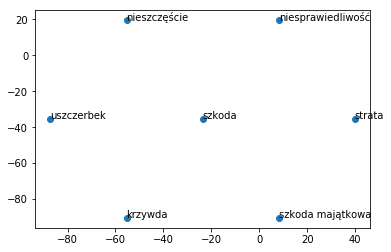

In [61]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

labels = [
    "szkoda",
    "strata",
    "uszczerbek",
    "szkoda majątkowa",
#     "uszczerbek na zdrowiu",
    "krzywda",
    "niesprawiedliwość",
    "nieszczęście"
]

X = np.array([do_vec(w) for w in labels])

X_embedded = TSNE(n_components=2).fit_transform(X)

# plot the result
vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]

fig, ax = plt.subplots()
ax.scatter(vis_x, vis_y)

for i, txt in enumerate(labels):
    ax.annotate(txt, (vis_x[i],vis_y[i]))
    
plt.show()